# Logisztikus regresszió

A logisztikus regresszió a nevével ellentétben valójában nem is regresszió, hanem egy klasszifikációs eljárás. Míg a regresszió esetén a modell kimenete egy valós szám (pl. az ételszállító cég profitja, vagy az ingatlan eladási ára), addig a klasszifikáció egy igen/nem választ ad a feature-ök alapján.

Az első példa adatsora egy egyetemi tárgy eredményeit tartalmazza. A két félévközi ZH (százalékban megadott) eredménye lesz a két feature, és azt szeretnénk a modellel predikálni, hogy vajon sikeresen teljesíteni fogja-e a hallgató a tárgyat. Ez egy igen/nem jellegű becslés, egy klasszifikációs probléma.

A logisztikus regresszió nagyon hasonlít a lineáris regresszióra. A modell paraméterei a $\theta$ súlyok, és az $x^{(i}$ feature-ök alapján a becslés a $\theta^T x^{(i}$ szorzaton alapul. Ez a szorzat viszont egy tetszőleges (akár negatív) valós szám lehet. A logisztikus regresszió ebből úgy csinál igen/nem döntést, hogy a $\theta^T x^{(i}$ szorzatot áttolja egy ún. logisztikus függvényen, melynek alakja

$$g(z) = \frac{1}{1+e^{-z}},$$

amit ki is rajzolhatunk:

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(0.5,1,'A logisztikus függvény')

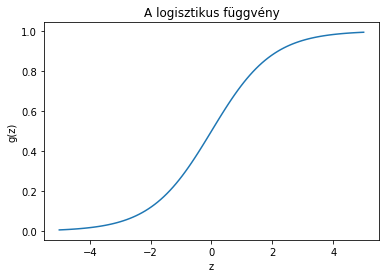

In [24]:
z = np.linspace(-5,5,100)
plt.plot(z, 1.0/(1.0+np.exp(-z)))
plt.xlabel("z")
plt.ylabel("g(z)")
plt.title("A logisztikus függvény")

Az ábrán jól látszik, hogy a logisztikus függvény bármilyen valós számhoz egy $(0,1)$ közötti számot rendel. A logisztikus regresszió tehát előállítja a 

$$ \hat{y}^{(i)}=g(\theta^T x^{(i}) = \frac{1}{1+e^{-\theta^T x^{(i}}}$$

értéket, és ez az érték azt mondja meg, hogy mennyire "esélyes", hogy a válasz "igen" legyen, pl. a példában: mennyire esélyes, hogy a hallgató teljesíti a tárgyat. 
Ezt könnyen igen/nem értékűre konvertálhatjuk, pl. ha $g(z)<0.5$, akkor "nem"-et, egyébként "igen"-t mondunk.

Sajnos a logisztikus függvény, bár ártalmatlannak tűnik, nehezen kezelhető analitikusan, így olyan szép zárt eredmény, mint a korábban látott normál egyenlet, itt nem írható fel. 
Sebaj, marad a numerikus optimalizálás, és a gradient descent (GD). Még annyit meg kell jegyezni, hogy a logisztikus regressziónál nem az MSE szokott lenni a loss függvény
(bár az is lehetne), hanem a cross entrópia:

$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^m y^{(i)} \log(\hat{y}^{(i)}) + (1-y^{(i)}) \log(1-\hat{y}^{(i)}).$$

Nem könnyű látni, de ez pont úgy működik, ahogy kell. Ha a valós kimenetel 1 volt ($y^{(i)}=1$), a második tag kinullázódik, és az első tagot próbálja minimalizálni az optimalizáló. Mivel azonban $1-\hat{y}^{(i)}$ mindig $0$ és $1$ közé esik, a $-\log(\hat{y}^{(i)})$ minimuma a $0$ lesz, ezt pedig a logaritmus 1 értéknél veszi fel, vagyis a $\hat{y}^{(i)}=1$-re törekszik az optimalizáló, pont, ahogy szeretnénk. Az $y^{(i)}=0$ eset ugyanígy látható, ekkor az első tag nullázódik ki. A logaritmikus célfüggvénynek az a szerepe, hogy a $J(\theta)$-ban lévő exponenciális tagot semlegesítse, mindig legyen erős grádiens a GD algoritmus számára.

Szerencsére az sklearn támogatja a logisztikus regressziót is. Próbáljuk aki az első példán:

In [25]:
# adatok betöltése
data = pd.read_csv("./data/simpleml/ex2data1.txt", names = ["ZH1", "ZH2", "Siker"])
data[0:10]

,ZH1,ZH2,Siker
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
5,45.083277,56.316372,0
6,61.106665,96.511426,1
7,75.024746,46.554014,1
8,76.098787,87.420570,1
9,84.432820,43.533393,1


A feature scaling-re most nincs szükség, a két feature azonos nagyságrendbe esik. Ábrázoljuk a két ZH eredményét, és a pontok színét a sikeresség szerint állítsuk be.

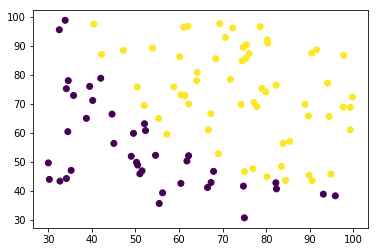

In [26]:
plt.scatter(data["ZH1"], data["ZH2"], c=data["Siker"])

Jöhet a regresszió!

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Az X mátrix és az y vektor összeállítása
m = len(data)
X = data[["ZH1","ZH2"]].values
y = data["Siker"].values
clf = LogisticRegression().fit(X, y)

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
# az optimális paraméterek:
print(clf.intercept_)
print(clf.coef_)

[-3.89977794]
[[0.03844482 0.03101855]]


In [29]:
# A költségfüggvény értéke:
ypred = clf.predict(X)
log_loss(y, ypred)

4.4901448790043155

Most, hogy meg vannak az optimális paraméterek, rajzoljuk ki a döntési határt ("decision boundary"), azaz azt a vonalat, ami felett sikeres tárgyteljesítést jósolunk, ami alatt pedig sikertelent. Gyakorlatilag a decision boundary az a vonal, ami alatt $\theta^T x^{(i}$ negatív, és ami felett $\theta^T x^{(i}$ pozitív.

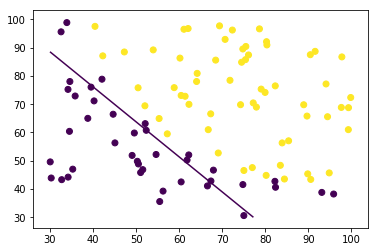

In [30]:
u = np.linspace(30, 80, 200)
v = np.linspace(30, 90, 200)
# kiszámítjuk a theta*x-et az u,v rács minden pontjában
J = np.array([[clf.intercept_[0] + ui*clf.coef_[0,0] + vj*clf.coef_[0,1] for ui in u] for vj in v])

# egyetlen kontúrt rajzolunk ki, a 0 érték mentén. Egyik oldalán pozitív, másikon negatív értékek lesznek
plt.contour(u,v,J, 0)
plt.scatter(data["ZH1"], data["ZH2"], c=data["Siker"])

Természetesen most is lehetőség van mesterséges feature-ökkel felturbózni a modellt. Most négyzetes tagokat és vegyesszorzatot hozunk be extra feature-ként.

In [31]:
Xv = np.hstack((X, np.power(X[:,0:1],2), np.power(X[:,1:2],2), X[:,0:1]*X[:,1:2]))
y = data["Siker"].values
clfv = LogisticRegression().fit(Xv, y)
ypred = clfv.predict(Xv)
log_loss(y, ypred)

/usr/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


9.992007221626413e-16

A loss függvény szerint egészen elképesztő a pontosság, valószínűleg tökéletesen sikerült a két halmaz szétválasztása. Rajzoljuk ki a decision boundary-t így is:

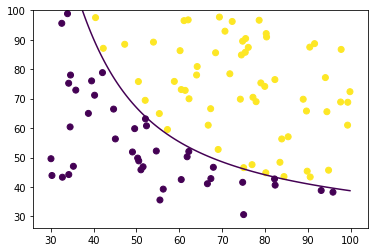

In [32]:
u = np.linspace(30, 100, 200)
v = np.linspace(30, 100, 200)
# kiszámítjuk a theta*x-et az u,v rács minden pontjában
#J = np.array([[clfv.intercept_[0] + ui*clfv.coef_[0,0] + vj*clfv.coef_[0,1] + ui**2*clfv.coef_[0,2] + vj**2*clfv.coef_[0,3] + ui**3*clfv.coef_[0,4] + vj**3*clfv.coef_[0,5] + (ui*vj)*clfv.coef_[0,6] for ui in u] for vj in v])
J = np.array([[clfv.intercept_[0] + ui*clfv.coef_[0,0] + vj*clfv.coef_[0,1] + ui**2*clfv.coef_[0,2] + vj**2*clfv.coef_[0,3] + (ui*vj)*clfv.coef_[0,4] for ui in u] for vj in v])

# egyetlen kontúrt rajzolunk ki, a 0 érték mentén. Egyik oldalán pozitív, másikon negatív értékek lesznek
plt.contour(u,v,J, 0)
plt.scatter(data["ZH1"], data["ZH2"], c=data["Siker"])

Konklúzió: a logisztikus regresszió és a lineáris regresszió hasznos dolgok, *HA* sikerül megfelelő feature-öket találnunk. 
De hogy találjunk jó feature-öket? A kérdést a neurális hálózatok fogják megválaszolni, melyek megtanulják a megfelelő feature-öket is.